## 物体検出・トラッキング

In [ ]:
import os
import numpy as np # 1.21.6
import cv2 # 4.1.2
import matplotlib.pyplot as plt
from yolov4.tf import YOLOv4 # 2.8.0
from scipy.optimize import linear_sum_assignment # 1.4.1
from filterpy.kalman import KalmanFilter # 1.4.5
from torch import tensor # 1.10.0+cu111
from torchvision.ops.boxes import box_iou as IoU # 0.11.1+cu111

# 固定値
YOLO_PARSE_NAME  = "/content/drive/MyDrive/YOLO/cnf/coco.names"
YOLO_PARSE_CFG   = "/content/drive/MyDrive/YOLO/cnf/yolov4-tiny.cfg"
YOLO_WEIGHT_FILE = "/content/drive/MyDrive/YOLO/wgt/yolov4-tiny.weights"
YOLO_PROB_THRESHOLD = 0.3
YOLO_DETECT_CAT  = 2
TRACK_MAX_AGE = 20
TRACK_MIN_HIT = 10
TRACK_IoU_THRESHOLD = 0.3
TRACK_NEW_TRACK_THRESHOLD = 0.6

FILE_PATH_OUTPUT = "/content/drive/MyDrive/YOLO/dat/OUTPUT.webm"
FILE_PATH_INPUT  = "/content/drive/MyDrive/YOLO/dat/car.mp4"

# デバッグ
if __debug__:
    DEMO_PLAY_TIME = 30

Call tf.config.experimental.set_memory_growth(GPU0, True)


## 動画ファイル読み込み

In [ ]:
# 動画ファイルから入力
cap = cv2.VideoCapture(FILE_PATH_INPUT)

# 動画ファイルの縦横サイズ
FRAME_WIDTH  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FRAME_COUNT  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
FPS = cap.get(cv2.CAP_PROP_FPS)

# デバッグ
if __debug__:
    FRAME_COUNT = int(FPS * DEMO_PLAY_TIME)

# 動画ファイル
FRAMES = [[]] * FRAME_COUNT

# 動画をすべて読み込み
for i in range(FRAME_COUNT):

    # 1フレーム読み込み
    _, f = cap.read()

    # BGR -> RGBに変換
    FRAMES[i] = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

# 解放
cap.release()

## 物体検出（yolov4）

In [ ]:
# YOLO
yolo = YOLOv4()
yolo.config.parse_names(YOLO_PARSE_NAME)
yolo.config.parse_cfg(YOLO_PARSE_CFG)

# YOLOモデル構築
yolo.make_model()
yolo.load_weights(YOLO_WEIGHT_FILE, weights_type="yolo")
yolo.summary(summary_type="yolo")
yolo.summary()

batch: 64
index layer No. filters  size/strd(dil)   input_shape         output_shape    1e9 flops
   0  convo_0      32      3 x 3 / 2      416 x 416 x   3 ->  208 x 208 x  32   0.075
   1  convo_1      64      3 x 3 / 2      208 x 208 x  32 ->  104 x 104 x  64   0.399
   2  convo_2      64      3 x 3 / 1      104 x 104 x  64 ->  104 x 104 x  64   0.797
   3  route_0       2,                                    ->  104 x 104 x  32
   4  convo_3      32      3 x 3 / 1      104 x 104 x  32 ->  104 x 104 x  32   0.199
   5  convo_4      32      3 x 3 / 1      104 x 104 x  32 ->  104 x 104 x  32   0.199
   6  route_1       5,  4,                                ->  104 x 104 x  64
   7  convo_5      64      1 x 1 / 1      104 x 104 x  64 ->  104 x 104 x  64   0.089
   8  route_2       2,  7,                                ->  104 x 104 x 128
   9  maxpo_0              2 x 2 / 2      104 x 104 x 128 ->   52 x  52 x 128   0.001
  10  convo_6     128      3 x 3 / 1       52 x  52 x 128 ->   52 

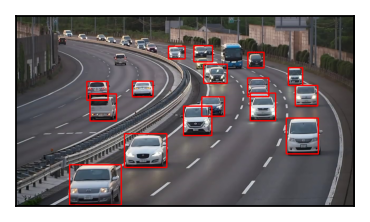

In [ ]:
DETECTIONS = []

for f in FRAMES:

    # 物体検出
    boxes = yolo.predict(frame=f, prob_thresh=YOLO_PROB_THRESHOLD)

    # ヒト以外のボックスを削除
    boxes = np.delete(boxes, np.where(boxes[:, 4] != YOLO_DETECT_CAT), axis=0)

    # ボックスの大きさを取得
    boxes = boxes * np.array([FRAME_WIDTH, FRAME_HEIGHT, FRAME_WIDTH, FRAME_HEIGHT, 1, 1])
    
    # ボックスの画面外にハミ出た所をトリミング
    boxes = [[
                int(max(0, b[0] - b[2]/2)),                 # 左上のx座標
                int(max(0, b[1] - b[3]/2)),                 # 左上のy座標
                int(min(FRAME_WIDTH  - 1, b[0] + b[2]/2)),  # 右下のx座標
                int(min(FRAME_HEIGHT - 1, b[1] + b[3]/2)),  # 右下のy座標
                int(b[4]),                                  # 物体の種類（ヒト=0）
                b[5]]                                       # 正確さ 0%～100%
                for b in boxes]
    
    # 検出リストに追加
    DETECTIONS.append(boxes)

# デバッグ
if __debug__:
    
    # 1フレーム目のコピー
    img = FRAMES[30].copy()

    # ボックス描画
    for b in DETECTIONS[30]:
        xy = tuple(np.array(b[:2],  dtype=int))
        wh = tuple(np.array(b[2:4], dtype=int))
        cv2.rectangle(img, xy, wh, (0xff, 0, 0), 3)

    # 画像表示
    plt.figure(dpi=160)
    plt.subplot(1, 2, 1)
    plt.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    plt.imshow(img)

## カルマンフィルタを用いたトラッキング用クラス

In [ ]:
class Track(KalmanFilter):

    __TRACK_COUNT = 0
    
    @property
    def boxpos(self): return self.cnvX2Box(self.x)
        
    def cnvX2Box(self, x):
        w = np.sqrt(x[2] * x[3])
        h = x[2] / w
        return np.array([x[0] - w/2., x[1] - h/2., x[0] + w/2., x[1] + h/2.]).reshape((1, 4))[0]

    def cnvBox2Z(self, bbox):
        wh = bbox[2:] - bbox[:2]
        xy = bbox[:2] + (wh / 2)
        return np.array([xy[0], xy[1], wh[0]*wh[1], wh[0]/wh[1]]).reshape((4, 1))

    def predict(self):
        super().predict()
        if self.time_since_update > 0: self.hits = 0
        self.time_since_update += 1

    def update(self, detection):
        self.time_since_update  = 0
        self.hits += 1
        super().update(self.cnvBox2Z(detection))

    def __init__(self, detection, category=0, score=0.):
        super(Track, self).__init__(dim_x=4, dim_z=4)

        Track.__TRACK_COUNT += 1
        self.id = Track.__TRACK_COUNT
        self.category, self.score, self.time_since_update, self.hits = category, score, 0, 0
        self.F = np.eye(4, 4) # motion_mat
        self.H = np.eye(4, 4) # update_mat
        self.x = self.cnvBox2Z(detection)


## トラッキング処理

In [ ]:
BBOXES = [] # x1, y1, x2, y2, id
tracks = []

for cnt, detection in enumerate(DETECTIONS):
    
    detection = np.array(detection)

    # 検出結果0件
    if len(detection) == 0:
        BBOXES.append(np.empty((0, 5)))
        continue

    # マッチング情報の初期化
    matched, unmatched_tracks, unmatched_detections = [], [], list(range(len(detection)))

    # predict
    for t in tracks:
        t.predict()

    if len(tracks) > 0:

        # IoU計算
        iou_matrix = np.zeros((len(detection), len(tracks)), float)
        for i, d in enumerate(detection):
            for j, t in enumerate(np.array([t.boxpos for t in tracks])):
                iou_matrix[i, j] = float(IoU(tensor([d[:4]]), tensor([t])))

        # 割り当て
        matched_index = np.array(linear_sum_assignment(-iou_matrix))

        # マッチしなかったdetection
        unmatched_detections = [i for i, _ in enumerate(detection) if i not in matched_index[0]]

        # マッチしなかったtrack
        unmatched_tracks = [i for i, _ in enumerate(tracks) if i not in matched_index[1]]

        # マッチしたdetection & track
        for m_det, m_trk in zip(matched_index[0], matched_index[1]):
            if iou_matrix[m_det, m_trk] < TRACK_IoU_THRESHOLD:
                unmatched_detections.append(m_det)
                unmatched_tracks.append(m_trk)
            else:
                matched.append([m_det, m_trk])

    # マッチしたtrackをUpdate
    for match in matched:
        tracks[match[1]].update(detection[[match[0]], :4][0])

    # 既存のtrackにないdetectionは新規追加
    for i in unmatched_detections:
        if detection[i, :][5] > TRACK_NEW_TRACK_THRESHOLD:
            trk = Track(detection[i, :4], detection[i, :][4], detection[i, :][5])
            tracks.append(trk)

    # max_ageフレーム連続で検出されない場合は削除
    tracks = [t for t in tracks if t.time_since_update <= TRACK_MAX_AGE]

    # update済、且つ指定回hitしたbboxを結果配列に追加
    BBOXES.append([np.append(t.boxpos, t.id) for t in tracks if t.time_since_update < 1 and TRACK_MIN_HIT <= t.hits])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


## 動画ファイル出力

In [ ]:
# ボックス書式
scale = 0.8
margin = 5
border = 3
fore_color = (0xFF, 0xFF, 0xFF)

# カラーパレット
COLOR_PALLET = [(0xff, 0, 0), (0, 0xff, 0), (0, 0, 0xff),
                (0x80, 0, 0), (0, 0x80, 0), (0, 0, 0x80),
                (0xff, 0xff, 0), (0xff, 0, 0xff), (0, 0xff, 0xff),
                (0x80, 0x80, 0), (0x80, 0, 0x80), (0, 0x80, 0x80),
                (0xff, 0x80, 0x80), (0x80, 0xff, 0x80), (0x80, 0x80, 0xff),
                (0xff, 0xff, 0x80), (0xff, 0x80, 0xff), (0x80, 0xff, 0xff)]

# 動画出力の準備
fourcc = cv2.VideoWriter_fourcc(*"VP80")
writer = cv2.VideoWriter(FILE_PATH_OUTPUT, fourcc, FPS, (FRAME_WIDTH, FRAME_HEIGHT))

for bbox, frame in zip(BBOXES, FRAMES):
    
    # RGB -> BGRに変換
    img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    for x1, y1, x2, y2, id in [[int(b[0]), int(b[1]), int(b[2]), int(b[3]), int(b[4])] for b in bbox]:
        
        # 色取得
        color = COLOR_PALLET[id % (len(COLOR_PALLET) - 1)]

        # 文字幅取得
        (fw, fh), _ = cv2.getTextSize(f"{id}", 0, scale, border)

        # ボックス描画
        cv2.rectangle(img, (x1, y1), (x2, y2), color, border)

        # 文字の囲い描画
        cv2.rectangle(img, (x1, y2 - fh - margin*2),(margin*2 + fw + x1, y2), color, -1)

        # 文字描画
        cv2.putText(img, f"{id}", (x1 + margin, y2 - margin), 0, scale, fore_color, border)
        
    writer.write(img)

# 終了処理
writer.release()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video = open(FILE_PATH_OUTPUT, "r+b").read()
encoded = b64encode(video)
play = lambda : HTML(data=f"'<video width='480' height='360' controls><source src='data:video/mp4;base64,{encoded.decode('ascii')}' type='video/mp4'/></video>'")

play()

Output hidden; open in https://colab.research.google.com to view.